<a href="https://colab.research.google.com/github/vrangayyan6/GenAI/blob/main/Gemini_Multi_Agent_Google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using AI to Streamline Research for Content Creation
## The Problem
Content creators, researchers, and marketers face a significant challenge when developing comprehensive material on specialized topics. The traditional research process is both time-consuming and labor-intensive:

- They must formulate effective search queries
- Sift through numerous search results manually
- Evaluate the relevance and credibility of sources
- Extract and organize key information
- Synthesize findings into coherent content
- Repeat this process multiple times to fill knowledge gaps

This workflow can take hours or even days, delaying content production and limiting the number of topics a team can cover effectively. For small teams or individual creators without research assistants, this bottleneck severely impacts productivity.

## The Solution
This notebook showcases how LangChain + LangGraph and other tools can be used to automate and optimize the research pipeline using agents ([see graph](https://drive.google.com/file/d/1qAq8IjjfSuVslKCnuHljdiVwcJXhlzZR/view?usp=drive_link))

Key capabilities:

- Query Optimization: The AI refines user queries to match search engine algorithms for better results (as shown in the format_search method)
- Automated Information Gathering: Instead of manual searching, the AI conducts multiple search queries and aggregates the results
- Intelligent Gap Analysis: The system evaluates the completeness of research and automatically identifies missing information (via the EditorAgent)
- Iterative Research: The AI conducts multiple rounds of research until sufficient information is gathered, targeting different aspects of the topic with each iteration
- Content Synthesis: When research is complete, the AI transforms raw research into well-structured content (via the WriterAgent)

## Real-World Impact
This AI-powered research workflow reduces what might take hours into minutes. Content creators can focus on refining and adding their unique perspective to AI-generated drafts rather than spending time on initial research and organization. The solution is particularly valuable for:

- Marketing teams needing to create content across multiple product lines
- Researchers exploring new domains quickly
- Educational content creators covering diverse topics
- Small businesses without dedicated research staff

By increasing the number of search results (as you've requested), the system becomes even more effective, gathering a wider range of perspectives and information in each research iteration.

## Environment Setup
Before we dive in, we prepare a custom Python environment and install the required libraries:

In [1]:
# Create a custom install directory
import os
# import shutil
# custom_path = "/kaggle/working/custom_env"
# if os.path.isdir(custom_path):
#     shutil.rmtree(custom_path)

# os.makedirs(custom_path, exist_ok=True)

# Install your desired packages into that path   --no-deps --target={custom_path}
!pip install -q langchain_community langgraph langgraph-prebuilt \
langchain  langsmith langchain_experimental langchain-google-genai langchain-google-community \
google-search-results langgraph-checkpoint ormsgpack filetype langchain_core langgraph_sdk \
pyppeteer requests beautifulsoup4 xxhash

# Prepend custom path to sys.path so Python loads from there
# import sys
# sys.path.insert(0, custom_path)

## Configure API Keys
We securely fetch API keys from Kaggle Secrets. You must add the following secrets in the Add-ons > Secrets menu:

GOOGLESEARCH_API_KEY — for Google Search API

GOOGLE_CSE_ID — Custom Search Engine ID

LANGCHAIN_API_KEY — for LangChain’s services

In [2]:
from google.colab import userdata

os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLESEARCH_API_KEY")
os.environ["GOOGLE_CSE_ID"] = userdata.get("GOOGLE_CSE_ID")
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')

## Enable Tracing
LangChain offers an optional tracing feature that helps in debugging complex chains and workflows.

In [3]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"

## Setup Data Storage
We initialize a simple in-memory list to store results from the agent workflow:

In [4]:
final_result = []  # List to store results from each step of the process

## Define Shared State
We use a TypedDict class to define and track the shared state between agents. This makes it easier to debug and enforce consistency.

In [5]:
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    """
    Manages the workflow's shared state as it moves between agents.

    Fields:
        query (list): History of query messages (as LangGraph messages)
        url (list): Links returned from the research agent
        research (list): Results returned from the research agent
        content (str): The generated blog post content
        content_ready (bool): Flag indicating if the content is complete
        iteration_count (int): Number of times the research step has run
    """
    query: Annotated[list, add_messages]
    url: Annotated[list, add_messages]
    research: Annotated[list, add_messages]
    content: str
    content_ready: bool
    iteration_count: int

## Initialize the Language Model
We use Google's Gemini model via LangChain’s wrapper.

In [6]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

## Research Agent
format_search(): Uses Gemini to transform natural queries into more search-optimized forms.

search(): Executes a search via GoogleSearchRun and stores results in state.

🔁 Iteration results are logged in final_result for each loop of query → search.

In [7]:
import time
from langchain_google_community import GoogleSearchAPIWrapper
# from langchain_google_community import GoogleSearchRun
# from googlesearch import search
from langchain_core.messages import HumanMessage
import requests
from bs4 import BeautifulSoup

class ResearchAgent:
    """
    Agent responsible for optimizing search queries and fetching research results.
    Acts as the initial step in the blog post creation workflow.
    """
    def format_search(self, query: str) -> str:
        """
        Optimizes a search query to improve search result relevance.

        Args:
            query (str): The original search query provided by the user

        Returns:
            str: An optimized version of the query for better search results
        """
        prompt = (
            "You are an expert at optimizing search queries for Google. "
            "Your task is to take a given query and return an optimized version of it, making it more likely to yield relevant results. "
            "Do not include any explanations or extra text, only the optimized query.\n\n"
            "Example:\n"
            "Original: best laptop 2023 for programming\n"
            "Optimized: top laptops 2023 for coding\n\n"
            "Example:\n"
            "Original: how to train a puppy not to bite\n"
            "Optimized: puppy training tips to prevent biting\n\n"
            "Now optimize the following query:\n"
            f"Original: {query}\n"
            "Optimized:"
        )

        response = llm.invoke(prompt)  # Use LLM to optimize the query
        return response.content

    def fetch_full_content(self, url: str) -> str:
        try:
            headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36'}
            response = requests.get(url, headers=headers, timeout=30)
            response.raise_for_status()  # Raise an exception for bad status codes
            soup = BeautifulSoup(response.content, 'html.parser')
            # Extract text content - you might need to adjust the selectors
            text_parts = soup.find_all('p')  # get all paragraph text
            full_text = "\n".join([part.get_text() for part in text_parts])
            if not full_text.strip():
                full_text = soup.get_text()[:5000]
            return f"{full_text[:5000]} " # Limit content length
        except requests.exceptions.RequestException as e:
            return f"URL: {url}\nError fetching content: {e}"
        except Exception as e:
            return f"URL: {url}\nError parsing content: {e}"

    def search(self, state: State):
        """
        Performs a Google search using the optimized query and updates the state.

        Args:
            state (State): Current workflow state containing the query

        Returns:
            dict: Updated state with research results
        """
        # Initialize the Google Search API wrapper first
        search_wrapper = GoogleSearchAPIWrapper(k=10)  # Configure to return top 10 results

        # Track execution time for performance monitoring
        start_time = time.perf_counter()
        optimized_query = self.format_search(state.get('query', "")[-1].content)  # Get and optimize the latest query
        end_time = time.perf_counter()

        raw_results = search_wrapper.results(optimized_query, 1)  # Execute the search

        if raw_results and raw_results[0].get('link'):
            url = raw_results[0]['link']
            full_content = self.fetch_full_content(url)
            time.sleep(1) # Be respectful of website rate limits
        else:
            full_content = "No content found"
            url = "No url found"

        # Record this iteration's results for logging/debugging
        final_result.append({"subheader": f"Research Iteration", "content": [raw_results], "time": end_time - start_time})

        return {"research": full_content, "url": url, "query": optimized_query}  # Return updated state

## Editor Agent
- Uses Gemini to inspect accumulated research.

- If results are sufficient, it sets content_ready = True.

- If insufficient, it generates a new improved query and continues the loop.

🔐 Includes a hard limit of 10 iterations to prevent infinite loops.

In [8]:
class EditorAgent:
    """
    Agent responsible for evaluating research results and determining if more research is needed.
    Acts as the decision-making component in the workflow.
    """
    def evaluate_research(self, state: State):
        """
        Evaluates if the current research is sufficient to write a comprehensive blog post.

        Args:
            state (State): Current workflow state containing queries and research

        Returns:
            dict: Updated state with evaluation results and either content_ready flag or new query
        """
        # Combine all existing queries and research results
        query = '\n'.join(message.content for message in state.get("query"))
        research = '\n'.join(message.content for message in state.get("research"))

        # Track iteration count to prevent infinite loops
        iteration_count = state.get("iteration_count", 1)

        if iteration_count is None:
            iteration_count = 1

        # Hard limit of 10 iterations to prevent endless loops
        if iteration_count >= 11:
            return {"content_ready": True}  # Force completion after 10 iterations

        prompt = (
            "You are an expert editor. Your task is to evaluate the research based on the query. "
            "If the information is sufficient to create a comprehensive and accurate blog post, respond with 'sufficient'. "
            "If the information is not sufficient, respond with 'insufficient' and provide a new, creative query suggestion to improve the results. "
            "If the research results appear repetitive or not diverse enough, think about a very different kind of question that could yield more varied and relevant information. "
            "Consider the depth, relevance, and completeness of the information when making your decision.\n\n"
            "Example 1:\n"
            "Used queries: What are the benefits of a Mediterranean diet?\n"
            "Research: The Mediterranean diet includes fruits, vegetables, whole grains, and healthy fats.\n"
            "Evaluation: Insufficient\n"
            "New query: Detailed health benefits of a Mediterranean diet\n\n"
            "Example 2:\n"
            "Used queries: How does solar power work?\n"
            "Research: Solar power works by converting sunlight into electricity using photovoltaic cells.\n"
            "Evaluation: Sufficient\n\n"
            "Example 3:\n"
            "Used queries: Effects of climate change on polar bears?\n"
            "Research: Climate change is reducing sea ice, affecting polar bear habitats.\n"
            "Evaluation: Insufficient\n"
            "New query: How are polar bears adapting to the loss of sea ice due to climate change?\n\n"
            "Now evaluate the following:\n"
            f"Used queries: {query}\n"
            f"Research: {research}\n\n"
            "Evaluation (sufficient/insufficient):\n"
            "New query (if insufficient):"
        )

        # Track execution time for performance monitoring
        start_time = time.perf_counter()
        response = llm.invoke(prompt)  # Use LLM to evaluate research quality
        end_time = time.perf_counter()

        evaluation = response.content.strip()

        # Record this iteration's evaluation for logging/debugging
        final_result.append({"subheader": f"Editor Evaluation Iteration", "content": evaluation, "time": end_time - start_time})

        # Parse response to determine next steps
        if "new query:" in evaluation.lower():
            # Extract new query suggestion if research is insufficient
            new_query = evaluation.split("New query:", 1)[-1].strip()
            return {"query": [new_query], "iteration_count": iteration_count + 1, "evaluation": evaluation}
        else:
            # Research is sufficient, proceed to content creation
            return {"content_ready": True, "evaluation": evaluation}

## Writer Agent
- Combines query and research into a single blog post.

- Uses Gemini to generate detailed, structured content (intro, body, conclusion).

In [9]:
class WriterAgent:
    """
    Agent responsible for writing the final blog post based on the research.
    Acts as the final step in the workflow once research is deemed sufficient.
    """
    def write_blogpost(self, state: State):
        """
        Generates a comprehensive blog post based on the query and research.

        Args:
            state (State): Current workflow state containing query and research data

        Returns:
            dict: Updated state with the final blog post content
        """
        query = state.get("query")[0].content  if isinstance(state.get("query", [""]), list) else state.get("query", "") # Get the original query
        research = "\n".join([f"[{i+1}] {message.content} \n" for i, message in enumerate(state.get("research", []))])  # Combine all research results
        references = "\n".join([f"[{i+1}] {message.content} \n" for i, message in enumerate(state.get("url", []))])

        prompt = (
            "You are an expert blog post writer. Your task is to take a given query and context, and write a comprehensive, engaging, and informative short blog post about it. "
            "Make sure to include an introduction, main body with detailed information, and a conclusion. Use a friendly and accessible tone, and ensure the content is well-structured and easy to read. "
            "Apply best practices to cite the sources you used by referring to the number in the square brackets. "
            "Add the References section at the bottom of the blog post."
            "Do not add anything other content not in the sources.\n\n"
            f"Query: {query}\n\n"
            f"Context:\n{research}\n\n"
            f"**References:**\n{references}"
            "Write a detailed and engaging blog post based on the above query and context."
        )

        response = llm.invoke(prompt)  # Use LLM to generate the blog post

        return {"content": response.content}

## Define the LangGraph
🔄 This creates a loop between search_agent → editor_agent → (search or writer).

In [10]:
from langgraph.graph import StateGraph, START, END

# Initialize the StateGraph
graph = StateGraph(State)  # Create workflow graph using the State class as schema

# Add agent nodes to the graph
graph.add_node("search_agent", ResearchAgent().search)  # Research node
graph.add_node("writer_agent", WriterAgent().write_blogpost)  # Writer node
graph.add_node("editor_agent", EditorAgent().evaluate_research)  # Editor node

# Set the entry point of the workflow
graph.set_entry_point("search_agent")  # Start with search

# Add direct edge from search to editor
graph.add_edge("search_agent", "editor_agent")

# Add conditional edges from editor based on research evaluation
graph.add_conditional_edges(
    "editor_agent",
    lambda state: "accept" if state.get("content_ready") else "revise",  # Decision function
    {
        "accept": "writer_agent",  # If research is sufficient, proceed to writing
        "revise": "search_agent"   # If more research needed, loop back to search
    }
)

# Add edge from writer to end the workflow
graph.add_edge("writer_agent", END)

# Compile the graph to make it executable
graph = graph.compile()

The following code renders the graph. ([see graph rendered on https://mermaid.live/](https://drive.google.com/file/d/1qAq8IjjfSuVslKCnuHljdiVwcJXhlzZR/view?usp=drive_link))

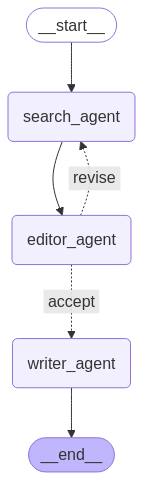

In [11]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

## Main Invocation Function
This function:

- Starts the LangGraph with the user’s query

- Automatically loops through agents until content_ready

- Returns the final blog post

In [12]:
def invoke_graph(user_prompt):
    """
    Main function to execute the entire blog post generation workflow.

    Args:
        user_prompt (str): The initial user query to research and write about

    Returns:
        str: The final blog post content
    """
    # Track total execution time
    start_time = time.perf_counter()
    blogpost = graph.invoke({"query": user_prompt})  # Start the workflow with user prompt
    end_time = time.perf_counter()
    print(f"Total time in completing the workflow: {end_time - start_time} seconds\n\n")  # Add spacing for readability in console output
    return blogpost["content"]  # Return the final blog post content

## Provide your prompt

In [13]:
user_prompt = "Act as an expert in Financial Services, explain in detail on separately managed accounts using 5000 words or more."

## View response
You will see the Google search results in the first section, and the blogpost generated in the next.

In [14]:
from IPython.display import Markdown

Markdown(invoke_graph(user_prompt))

Total time in completing the workflow: 83.3635227530001 seconds




## Diving Deep into Separately Managed Accounts (SMAs): A Comprehensive Guide

In the world of financial services, investors are constantly seeking personalized and tax-efficient ways to manage their wealth. One such avenue is the Separately Managed Account (SMA). But what exactly is an SMA, and how does it work? Let's delve into the details of SMAs, exploring their features, benefits, and suitability for different investors.

### What is a Separately Managed Account (SMA)?

A Separately Managed Account (SMA) is a portfolio of individual securities managed by a professional investment firm on behalf of an individual investor [4, 5]. Unlike mutual funds or Exchange-Traded Funds (ETFs), where investors own shares of a fund, in an SMA, the investor directly owns the individual securities within the portfolio [5]. This direct ownership is a key differentiator, offering a range of potential benefits.

Financial services providers are using several terms in addition to direct indexing to describe this technology, including personalized indexing and custom indexing [9].

### Key Features of Separately Managed Accounts:

1.  **Customization:**
    *   SMAs offer a high degree of personalization [5]. Portfolios can be tailored to align with an investor's specific financial goals, risk tolerance, and even values [3, 5, 9].
    *   Investors can impose restrictions on the purchase of certain securities, customizing the portfolio to meet their unique requirements [4].
    *   This personalization extends to various aspects, such as factor tilts, sector exclusions, or alignment with specific values [5]. Fixed income investors can customize around duration, credit quality, or state specificity [5].
2.  **Direct Ownership:**
    *   As the investor directly owns the securities, they have more control and transparency over the portfolio's holdings [4, 5].
    *   This direct ownership unlocks opportunities for tax management that are not available with mutual funds or ETFs [9].
3.  **Professional Management:**
    *   SMAs provide access to institutional-quality money managers [4]. These managers bring expertise in security selection, portfolio construction, and ongoing monitoring.
    *   Firms conduct in-depth manager research to select some of the world's best institutional investment managers [4].
4.  **Tax Efficiency:**
    *   SMAs offer potential for tax-loss harvesting, a strategy that can improve after-tax returns [3, 5, 6, 9].
    *   Tax-loss harvesting involves selling securities that have declined in value to realize capital losses [6]. These losses can then be used to offset capital gains, reducing overall tax liability [3, 5, 6, 9].
    *   SMAs provide the flexibility to fund accounts with existing securities, allowing investors to shift portfolios to a new strategy without the tax cost of liquidating highly appreciated securities [5].
5.  **Transparency:**
    *   Investors have a clear view of the securities held within their SMA [5]. This transparency allows for a better understanding of the portfolio's composition and performance.

### Benefits of Separately Managed Accounts:

1.  **Personalized Investment Experience:**
    *   SMAs offer a personalized investment experience, tailoring the portfolio to an investor's unique goals, needs, tax situation, and risk profile [3].
2.  **Potential for Tax Alpha:**
    *   Active tax management strategies, such as tax-loss harvesting, can generate "tax alpha," enhancing after-tax returns [3, 9].
    *   The ability to harvest losses at the individual security level, even in a rising market, can lead to significant tax benefits [9].
3.  **Flexibility and Control:**
    *   Investors have greater flexibility and control over their investments compared to pooled investment vehicles [4, 5].
    *   They can express their preferences and values through customized portfolio construction [5].
4.  **Access to Institutional Expertise:**
    *   SMAs provide access to professional money managers and their expertise [4].
    *   Investors benefit from the manager's research, selection, and monitoring of investments [4].

### Tax-Loss Harvesting in Detail:

Tax-loss harvesting is a key strategy employed within SMAs to enhance after-tax returns [3, 5, 6, 9]. Here's a closer look at how it works:

1.  **Identifying Losses:**
    *   The investment manager regularly scans the portfolio for securities that have declined in value below their cost basis [9].
2.  **Realizing Losses:**
    *   The manager sells the losing securities, "harvesting" the capital loss [3, 6, 9].
3.  **Repurchasing Replacements:**
    *   To maintain the desired asset allocation and market exposure, the manager immediately repurchases correlated, but not "substantially identical," replacement securities [9]. This step is crucial to avoid violating the "wash-sale rule," which disallows the deduction of a loss if the same or a substantially identical security is repurchased within 30 days [9].
4.  **Offsetting Gains:**
    *   The realized capital losses can be used to offset capital gains realized within the portfolio or even gains from outside sources [3, 5, 6, 9].
    *   In the U.S., capital losses can also offset up to $3,000 of ordinary income per year [6, 9]. Any remaining losses can be carried forward to future tax years [9].

**Example:**
Imagine an investor holds Security A, purchased for $10,000. It declines in value to $7,000. The manager harvests the $3,000 loss and immediately reinvests the proceeds in Security B, with similar characteristics. Later, Security B is sold for $10,000, resulting in a $3,000 gain. While the investor ultimately breaks even on the investment, the $3,000 loss could have been used to offset other capital gains, resulting in a tax benefit [6].

### Who Benefits from SMAs?

SMAs are not a one-size-fits-all solution [5]. They are generally best suited for:

1.  **High-Net-Worth Individuals:**
    *   SMAs typically have higher account minimums, making them more accessible to wealthier investors [5, 9].
    *   High-net-worth individuals often have more complex financial situations and can benefit from the personalized investment management and tax optimization offered by SMAs [3, 5].
2.  **Tax-Conscious Investors:**
    *   Investors seeking to minimize their tax liabilities can benefit from the tax-loss harvesting strategies employed within SMAs [3, 5, 6, 9].
3.  **Investors with Specific Preferences:**
    *   Those who want to align their investments with their values or have specific investment restrictions can leverage the customization options available with SMAs [5].
4.  **Investors Seeking Transparency and Control:**
    *   The direct ownership and transparency of SMAs appeal to investors who want a clear understanding of their portfolio holdings and greater control over investment decisions [4, 5].

### Potential Drawbacks of SMAs:

1.  **Higher Costs:**
    *   SMAs typically have higher fees compared to mutual funds or ETFs [5].
2.  **Account Minimums:**
    *   The higher account minimums can be a barrier to entry for some investors [5, 9].
3.  **Complexity:**
    *   Managing individual securities can be more complex than investing in a diversified fund [5].
4.  **Potential for Tracking Error:**
    *   If an SMA is designed to track a specific index, there may be some deviation in performance due to the customization and tax-loss harvesting activities [3].

### Direct Indexing with ETFs
For taxable clients, the best way to direct index is through ETFs that are tailored to provide the desired market exposure plus tax benefits [3]. The active tax management discipline aims to deliver tax efficiency through a loss capture process that is designed to help offset both capital gains within the portfolios and realized gains outside of the portfolios [3].

### Conclusion:

Separately Managed Accounts offer a compelling combination of personalization, tax efficiency, and professional management. While they may not be suitable for every investor, SMAs can be a valuable tool for high-net-worth individuals and others seeking a more tailored and tax-optimized investment experience. As always, it's crucial to consult with a qualified financial advisor to determine if an SMA is the right choice for your individual circumstances.

# Blogpost for Gen AI Intensive Course Capstone 2025Q1
This is the link to the blogpost https://www.linkedin.com/pulse/supercharging-content-creation-ai-research-agents-vinod-v--pwjte

# YouTube video
This is the link to the YouTube video https://youtu.be/XUpenymdGDQ